In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display, HTML, Markdown, Image, Video
from ipywidgets import interact, FloatSlider, IntSlider, Button, Output 
display(HTML("<style>.rendered_html.text_cell_render {max-width:600px; }</style>")) 

# Visualizations for Diffusion Blog Post

Visualizations for our blog post: [Deriving the simplified training loss for diffusion models](https://cgn.ai/blog/diffusion_101.html)

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np


sqrt = torch.sqrt    
ten = torch.tensor
def N0(size): return torch.normal(0, 1, size=size)

## Hyperparams

Mainly the interpolation schedule for the means and variances of the Markov transition kernels, and the overall length of the chain.

**Note:** We believe in short variable names for quick scientific prototyping, and we read `x_` as "x bar" and translate it to $\bar{x}$.

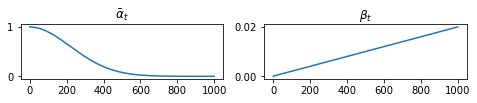

In [ ]:
T = 1_000 # diffusion steps
B = 8     # batch size

# 
# Definitions for $\alpha$, $\beta$, $\bar\alpha$ from the 
# paragraph before Eq. 4, and $\tilde\beta$ from Eq. 7
# 
# Values from Section 4 are chosen over 1000 timesteps, we adjust 
# accordingly by scaling them so the $\bar\alpha_t$ values are 
# roughly in the same range.
# 
b  = 1_000/T * torch.linspace(1e-4, .02, T)
a  = 1 - b
a_ = torch.cumprod(a, dim=0)

# adjust domains so we can use the indices in the paper
b  = torch.tensor([0.0,*b])
a  = torch.tensor([1.0,*a])
a_ = torch.tensor([1.0,*a_])

assert len(a) == len(b) == len(a_)

# Section 3.2 suggests two extreme choices 
# for $\sigma_t$ one is simply
sig = sqrt(b)


# weight used in the loss term given in Eq. 12
# and in `loss_func` below ...
w_loss = w = b**2 / ( 2*sig**2 * a * (1 - a_) )

# ----------------------
fig, axs = plt.subplots(1,2,figsize=(8,1));
axs[0].set_title(r"$\bar\alpha_t$");
axs[0].plot(a_);
axs[1].set_title(r"$\beta_t$");
axs[1].plot(b);

## Model parts and distributions

Bits and pieces of the forward and backward model.

In [ ]:
from cgnai.utils import defaultfrom
# Decorator that bins values from a context to
# default keyword-only (!) arguments of a function.

context = dict(
    beta   = b, 
    alpha  = a, 
    alpha_ = a_, 
    sig    = sig, 
    T = T,
    B = B)


@defaultfrom(context)
def q_step(x, t, *, alpha, beta, eps=None):
    """
    One forward diffusion step, i.e
    returns a sample from 
    $$
        q(x_t \mid x_{t-1}=x).
    $$
    """
    if eps is None: eps = N0(x.size())
    return sqrt(alpha[t])*x + sqrt(beta[t])*eps


@defaultfrom(context)
def q_rollout(x0, t, *, alpha, beta):
    """
    Random roll out of `t` diffusion steps starting at `x0`, i.e.
    returns a sample from 
    $$
        q(x_1, \ldots, x_t \mid x_0).
    $$
    """
    xt    = torch.zeros(t+1, *x0.size())
    xt[0] = x0
    for s in range(1,t+1): xt[s] = q_step(x=xt[s-1], t=s, alpha=alpha, beta=beta)
    return xt


@defaultfrom(context)
def q_t(x0, t, *, alpha_, eps=None):
    """
    The forward model from Eq. 4:
    $$
        q(x_t \mid x_0).
    $$
    """    
    if eps is None: eps = N0(x0.size())
    t  = t
    xt = sqrt(alpha_[t])*x0 + sqrt(1-alpha_[t])*eps
    return xt


@defaultfrom(context)
def mu_tilde(x0, xt, t, * , alpha, beta, alpha_):
    """
    The mean of the $x_0$-conditioned reverse 
    diffusion step:
    $$
        \tilde{\mu}(x_t, x_0).
    $$
    """        
    aa = sqrt(alpha_[t-1])*beta[t]/(1 - alpha_[t])
    bb = sqrt(alpha[t])*(1 - alpha_[t-1])/(1 - alpha_[t])
    return aa*x0 + bb*xt


@defaultfrom(context)
def beta_tilde(t, *, beta, alpha_, ):
    """
    The variance of the $x_0$-conditioned reverse 
    diffusion step:
    $$
        \tilde{\beta}_t
    $$
    """ 
    return (1 - alpha_[t-1])/(1 - alpha_[t])*beta[t]


@defaultfrom(context)
def q_tilde(x0, xt, t, * , alpha, beta, alpha_):
    """
    Mean and variance of the $x_0$-conditioned 
    reverse diffusion step
    $$
        \tilde{q}( x_{t-1} \mid x_t, x_0).
    $$
    """
    mu  = mu_tilde(x0, xt, t, alpha=alpha, beta=beta, alpha_=alpha_)
    var = beta_tilde(t, alpha_=alpha_, beta=beta)
    return  mu, var 

## Initial distribution

Lets start with our initial data distribution $Q_0$ wich we
define as Gaussian mixuture (`gm` below).

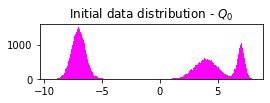

In [ ]:
from cgnai.plotting import ani
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
plt.rcParams.update({'font.size': 10})

mix  = torch.distributions.Categorical(torch.tensor([1.,2.,3.]))
comp = torch.distributions.Normal(torch.tensor([7.,4.,-7.]), torch.tensor([.3, 1.,.6]))
gm   = torch.distributions.MixtureSameFamily(mix, comp)
# -----------------------
plt.figure(figsize=(4,1))
plt.title(f"Initial data distribution - $Q_0$")
plt.hist(gm.sample((50_000,)).numpy(), bins=200, color="magenta");

## Random Rollouts

Collect samples from $q(x_0,x_1,\ldots,x_T)$ ...

In [ ]:
S  = 10_000 # Number of samples
x0 = gm.sample((S,))
ts = torch.arange(T+1).view(-1,1).repeat((1,S))
xs = q_rollout(x0, T)
xs.size()

torch.Size([1001, 10000])

## Figures 

Here we generate **Figure 1** and **Figure 2** from our diffusion blog post.

### Forward diffusion animation

Here we generate **Figure 1**.

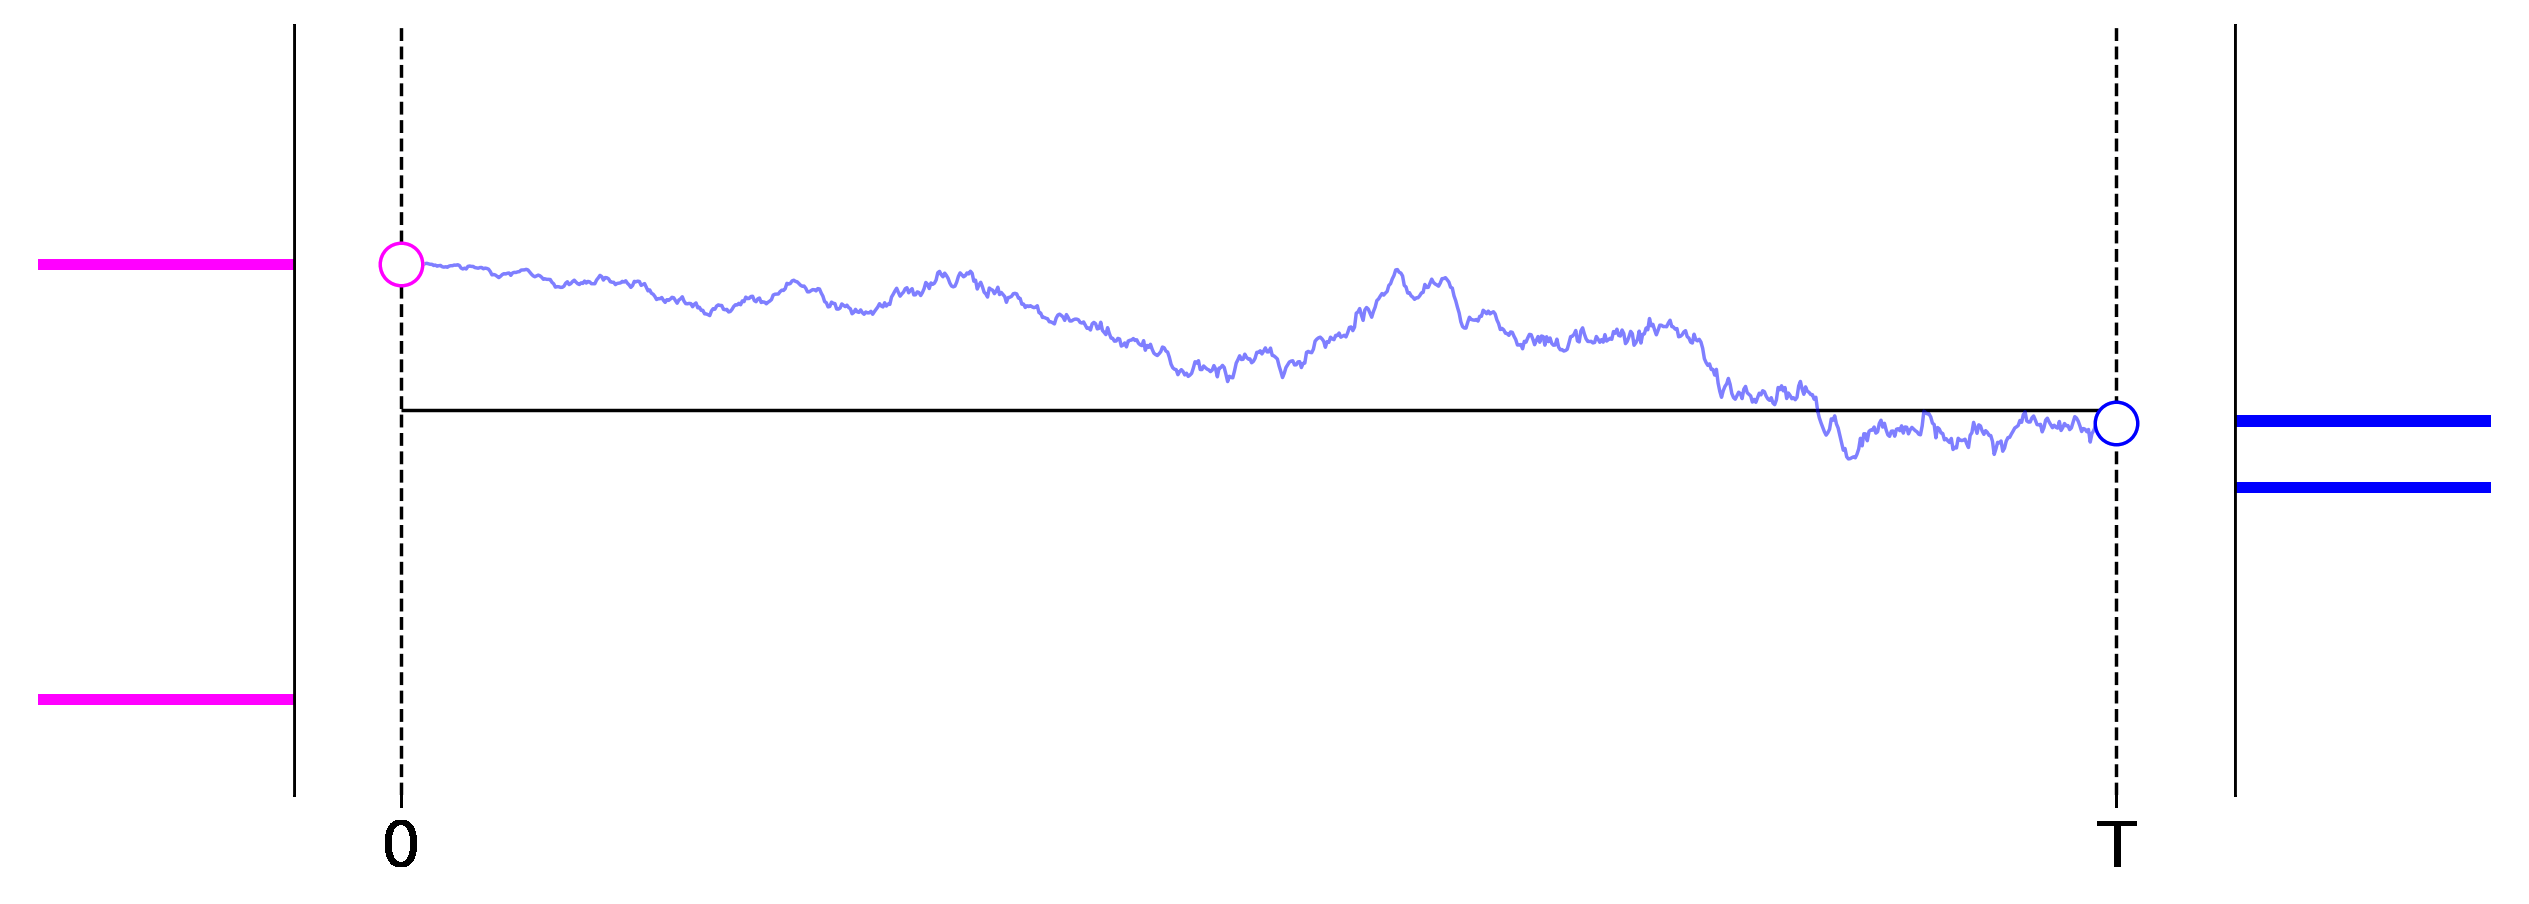

In [ ]:
# Collection of fnames for all 
# the frames in the final gif
F = [] 

# Create temporal folder to store 
# animation frames
folder = "_ani_temp"
!mkdir -p $folder


ylims = (-10,10)
# ------------------------------
plt.rcParams.update({'font.size': 18})
for i in range(1, 1_000, 20):
    print(f"{i}", end="\r")
    fig, axs = plt.subplot_mosaic([[0,1,2]], 
                                  sharey=True,
                                  gridspec_kw = dict(
                                      width_ratios=[1, 7., 1], 
                                      height_ratios=[1]),
                                  figsize=(10, 3.5), 
                                  layout="constrained")
    plt.ylim(*ylims)
    #
    #
    #
    axs[1].plot(xs[:,i], c="b", alpha=.5, linewidth=1, zorder=3)
    axs[1].scatter(0, x0[i],    marker="o", c="w", edgecolor="magenta", linewidth=1,  s=150, alpha=1, zorder=10)
    axs[1].scatter(T, xs[-1,i], marker="o", c="w", edgecolor="b", s=150, alpha=1, zorder=10)
    axs[1].vlines(0, *ylims, color="k", alpha=1., linestyle="--", linewidth=1, zorder=0)
    axs[1].vlines(T, *ylims, color="k", alpha=1., linestyle="--", linewidth=1, zorder=0)
    axs[1].hlines(0,0,T, color="k", alpha=1., linestyle="-", linewidth=1, zorder=0)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].set_xticks([0,T],["0","T"])
    
    
    axs[2].hist(xs[-1,:(i+1)].numpy(), 
                bins=np.linspace(*ylims, 70), 
                color="b",
                orientation='horizontal')
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['bottom'].set_visible(False)
    axs[2].set_ylim(*ylims)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    
    
    axs[0].hist(x0[:(i+1)].numpy(), 
                bins=np.linspace(*ylims, 70), 
                color="magenta",
                orientation='horizontal')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].set_ylim(*ylims)
    axs[0].set_xlim(axs[2].get_xlim()[::-1])
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    
    fname = f"{folder}/{i}.png"
    F.append(fname)
    plt.savefig(fname, bbox_inches='tight', dpi=250)
    plt.close()

    
# Create the gif animation
fname = "diffusion_rollouts.gif"
ani(fname, F)
Image(fname, width=500)

### Sample efficiency

Here we generate **Figure 2**.

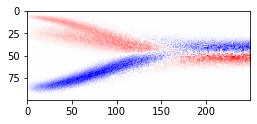

In [ ]:
plt.rcParams.update({'font.size': 10})

bins = (250,100)

dx = xs[1:] - xs[:-1]
h,_,_ = np.histogram2d(ts[1:,:].numpy().flatten(),
                       xs[1:,:].numpy().flatten(), 
                       weights= - dx.numpy().flatten(), 
                       bins=bins)
val = 25
# ---------
plt.figure(figsize=(4,2));
plt.imshow(h[:,::-1].T, vmin=-val, vmax=val, cmap="bwr");

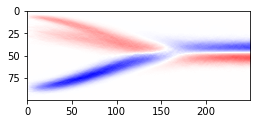

In [ ]:
mus  = mu_tilde(xs[[0],:], xs, ts)
dmus = mus[:] - xs[:]

h_mu,_,_ = np.histogram2d(ts[:,:].numpy().flatten(),
                          xs[:,:].numpy().flatten(), 
                          weights=dmus.numpy().flatten(), 
                          bins=bins )

# ---------
plt.figure(figsize=(4,2));
plt.imshow(h_mu[:,::-1].T, vmin=-val, vmax=val, cmap="bwr");

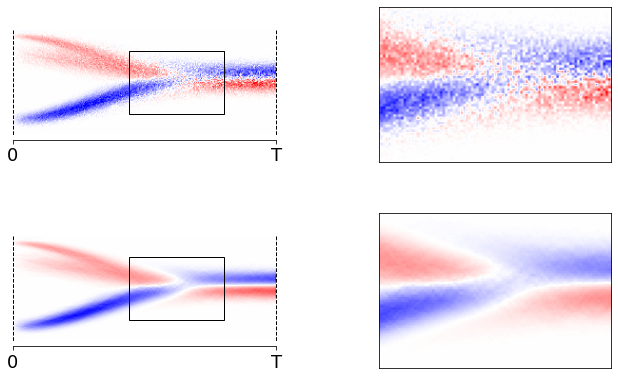

In [ ]:
xlims = (110,200)
ylims = (20,80)

W = xlims[1] - xlims[0]
H = ylims[1] - ylims[0]
pos = (xlims[0], ylims[0])
rect1 = Rectangle(pos, W,H, linewidth=1, edgecolor='k', facecolor='none')
rect2 = Rectangle(pos, W,H, linewidth=1, edgecolor='k', facecolor='none')


# ----------------
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(2,2, figsize=(10,6));
fig.tight_layout()

axs[0,0].imshow(h[:,::-1].T, vmin=-val, vmax=val, cmap="bwr")
axs[0,0].add_patch(rect1)
axs[0,0].vlines(0, 0, h.shape[1],          color="k", alpha=1., linestyle="--", linewidth=1, zorder=0)
axs[0,0].vlines(h.shape[0], 0, h.shape[1], color="k", alpha=1., linestyle="--", linewidth=1, zorder=0,clip_on=False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['left'].set_visible(False)
axs[0,0].set_yticks([])
axs[0,0].set_xticks([0,h.shape[0]], labels=[0,"T"])
axs[0,0].set_xlim(0,h.shape[0])


axs[0,1].set_xlim(*xlims)
axs[0,1].set_ylim(ylims[1], ylims[0])
axs[0,1].imshow(h[:,::-1].T, vmin=-val, vmax=val, cmap="bwr")
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])


axs[1,0].imshow(h_mu[:,::-1].T, vmin=-val, vmax=val, cmap="bwr")
axs[1,0].add_patch(rect2)
axs[1,0].vlines(0, 0, h.shape[1], color="k", alpha=1., linestyle="--", linewidth=1, zorder=0)
axs[1,0].vlines(h.shape[0], 0, h.shape[1], color="k", alpha=1., linestyle="--", linewidth=1, zorder=0, clip_on=False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].set_xlim(0,h.shape[0])
axs[1,0].spines['left'].set_visible(False)
axs[1,0].set_yticks([])
axs[1,0].set_xticks([0,h.shape[0]], labels=[0,"T"])


axs[1,1].set_xlim(*xlims)
axs[1,1].set_ylim(ylims[1], ylims[0])
axs[1,1].imshow(h_mu[:,::-1].T, vmin=-val, vmax=val, cmap="bwr")
axs[1,1].set_xticks([])
axs[1,1].set_yticks([]);

plt.savefig("sample_efficiency",bbox_inches='tight', dpi=300)